In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import time

# Model Kou

Model Kou to model dyfuzji skokowej, w którym proces ceny instrumentu bazowego (już przy mierze martyngałowej  $\mathbb{Q}$) spełnia następujące stochastyczne równanie różniczkowe:
### $$dS_{t}=\underbrace{\left(r-q-\lambda\zeta\right)S_{t}}_{a(S_t)}dt+\underbrace{\sigma S_{t}}_{b(S_t)}dW_{t}+\underbrace{S_{t-}}_{c(S_{t-})}dJ_{t}$$


gdzie:


• $r$ - stopa wolna od ryzyka

• $q$ - stopa dywidendy

• $\zeta=\frac{p\eta_{1}}{\eta_{1}-1}+\frac{q\eta_{2}}{\eta_{2}+1}-1$

• $\sigma>0$ - parametr zmienności 

• $W$ - proces Wienera

• $\displaystyle J_t =\sum_{k=1}^{N_{t}}(V_{k} - 1)$ - złożony proces Poissona z parametrem intensywności $\lambda >0$, gdzie $Z_k = \ln{(V_{k})}$ ma rozkład $\textbf{podwójnie wykładniczy}$ o gęstości 

#### $$f_{Z}\left(z\right)=p\eta_{1}e^{-\eta_{1}z}1_{\{z\geq0\}}+\left(1-p\right)\eta_{2}e^{\eta_{2}z}1_{\{z<0\}},$$

gdzie $\eta_{1}>1$, $\eta_{2}>0$, natomiast $p\in\left[0,1\right]$ interpretujemy jako prawdopodobieństwo skoku w górę. Innymi słowy 
#### $$Z_{k}=\ln\left(V_{k}\right)\stackrel{d}{=}\begin{cases}
\xi^{+}, & \text{z prawdopodobieństwem }p\\
-\xi^{-}, & \text{z prawdopodobieństwem }1-p
\end{cases},$$
gdzie $\xi^{+}$ i $\xi^{-}$ mają rozkład wykładniczy odpowiednio z parametrami $\eta_{1}$ i $\eta_{2}$. 


Rozwiązaniem omawianego stochastycznego równania różniczkowego jest proces: 
### $$\boxed{S_{t}=S_{0}e^{\left(r-q-\lambda\zeta-\frac{\sigma^{2}}{2}\right)t+\sigma W_{t}+\sum_{k=1}^{N_{t}}Z_{k}}}$$


In [2]:
# Parametry 
S0 = 100
r = 0.019
q = 0.012
T = 1
sigma = 0.2
lam = 5
p = 0.5
eta_1 = 20
eta_2 = 30
N = 252 

zeta = (p * eta_1) / (eta_1 - 1) + ((1 - p) * eta_2) / (eta_2 + 1) - 1
dryf = r - q - lam * zeta

In [3]:
# Współczyniki równania różniczkowego

def a(x):
    return dryf * x

def b(x):
    return sigma * x

def c(x):
    return x

# pochodne cząstkowe po x

def a_x(x):
    return dryf 

def a_xx(x):
    return 0

def b_x(x):
    return sigma

def b_xx(x):
    return 0

### Proces Wienera

In [4]:
# Trajektorie procesu Wienera

def Wiener_path(T, N):
    
    h = float(T / N)
    sq_h = np.sqrt(h)
    
    t = np.linspace(0, T, N + 1)
    W = np.zeros(N + 1)
    
    Normals = np.random.normal(0, 1, N)

    for i in range(N):
        W[i + 1] = W[i] + sq_h * Normals[i]
        
    return t, W

### Złożony proces Poissona (skoki o rozkładzie podwójnie wykładniczym)

In [5]:
# Funkcja generująca skoki z rozkładu podwójnie wykładniczego

def DExp(p, eta_1, eta_2, number_of_jumps):
    
        double_exp = np.zeros(number_of_jumps)

        for i in range (number_of_jumps):
            Unif = np.random.rand() 
            if Unif <= p:    # jeśli prawda to skok w góre 
                double_exp[i] = np.random.exponential(1 / eta_1)        #rozkład wykładniczy z parametrem eta_1 (w Pythonie 1/eta_1)
            else:            # w innym wypadku skok w dół (stąd znak -)
                double_exp[i] = - np.random.exponential(1 / eta_2)      #rozkład wykładniczy z parametrem eta_2 (w Pythonie 1/eta_2)

        return double_exp  

In [6]:
# Trajektorie złożonego procesu Poissona (metoda przyrostów)

def Comp_Poiss_path(T, N, lam, p, eta_1, eta_2):
    
    h = float(T / N)
    lh = lam * h
    
    t = np.linspace(0, T, N + 1)     # oś czasu

    dN = np.random.poisson(lh, N)    # przyrosty procesu Poissona
    N_ = np.cumsum(dN)               # trajektoria procesu Poissona 
    N_ = np.insert(N_, 0, 0.0)       # proces startuje z 0
    
    Y = np.zeros(N + 1)              # złożony proces Poissona

    jumps = DExp(p, eta_1, eta_2, N_[-1])       # wektor przechowujący wielkości skoków, N_[-1] - liczba skoków

    for i in range(1, N + 1):
        S = 0.0
        for k in range(N_[i]):      # N_[i] - liczba skoków do chwili t = i * h
            S += jumps[k]           # sumujemy N_[i] skoków
        Y[i] = S

    return t, Y

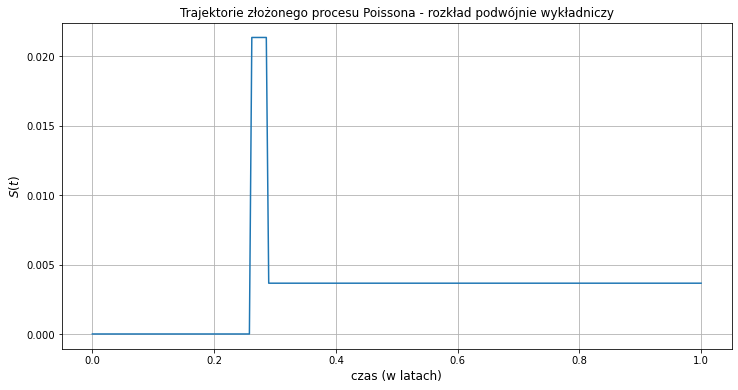

In [7]:
t,Y = Comp_Poiss_path(T, N, lam, p, eta_1, eta_2)

plt.figure(figsize = (12, 6))
plt.plot(t, Y)
plt.xlabel('czas (w latach)', size = 12)
plt.ylabel('$S(t)$', size = 12)
plt.title("Trajektorie złożonego procesu Poissona - rozkład podwójnie wykładniczy")
plt.grid()
plt.show()

### Trajektorie w modelu Kou (rozwiązanie dokładne)

In [8]:
# Trajektoria z rozwiązania dokładnego

def exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    Y = Comp_Poiss_path(T, N, lam, p, eta_1, eta_2)[1]
    W = Wiener_path(T, N)[1]
    
    t = np.linspace(0, T, N + 1)
    S = np.zeros(N + 1)
    
    zeta = (p * eta_1) / (eta_1 - 1) + ((1 - p) * eta_2) / (eta_2 + 1) - 1
    dryf = r - q - lam * zeta - 0.5 * sigma ** 2
    
    S = S0 * np.exp(dryf * t + sigma * W + Y)
    
    return t, S

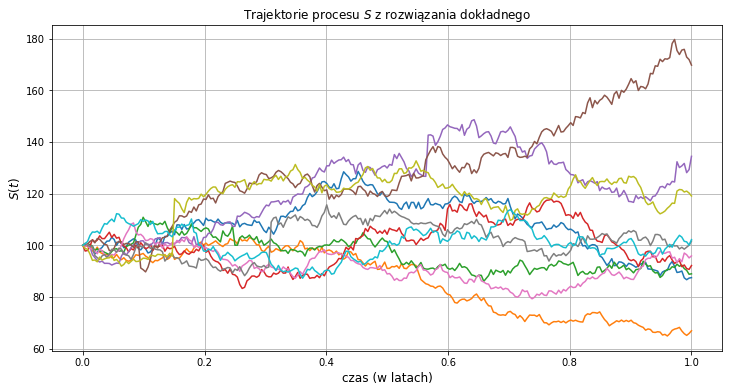

In [9]:
plt.figure(figsize = (12, 6))
for i in range(10):
    t, S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)
    plt.plot(t, S)
plt.xlabel('czas (w latach)', size = 12)
plt.ylabel('$S(t)$', size = 12)
plt.title("Trajektorie procesu $S$ z rozwiązania dokładnego")
plt.grid()
plt.show()

In [10]:
# Dokładna wartość procesu S w chwili T

def exact_value_T(S0, T, r, q, sigma, lam, p, eta_1, eta_2, W_T, Y_T): 
                                                                                                        
    zeta = (p * eta_1) / (eta_1 - 1) + ((1 - p) * eta_2) / (eta_2 + 1) - 1
    dryf = r - q - lam * zeta - 0.5 * sigma ** 2
    
    S_T = S0 * np.exp(dryf * T + sigma * W_T + Y_T)
    
    return S_T

## Schemat Eulera

W modelu Kou, schemat Eulera wygląda następująco:
### $$\boxed{S_{t+\Delta t}=S_{t}+a\left(S_{t}\right)\Delta t+b\left(S_{t}\right)\Delta W_{t}+c\left(S_{t}\right)\Delta J_{t}}$$
### $$\boxed{\Delta J_t = \sum_{k=N_{t}+1}^{N_{t+\Delta t}}(V_k - 1)}$$

In [11]:
# Trajektoria ze schematu Eulera

def Euler_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    S = np.zeros(N + 1)
    S[0] = S0
    
    t = np.linspace(0, T, N + 1)
    h = float(T / N)
    sq_h = np.sqrt(h)
    lh = lam * h
    
    W = 0
    Y = 0
    
    for i in range(1, N + 1):
        dN = np.random.poisson(lh)
        jumps = DExp(p, eta_1, eta_2, dN)
        dJ = np.sum(np.exp(jumps) - 1)
        dW = sq_h * np.random.normal(0, 1)
        
        S[i] = S[i - 1] + a(S[i - 1]) * h + b(S[i - 1]) * dW + c(S[i - 1]) * dJ 
       
        W += dW
        Y += np.sum(jumps)    
        
    return t, S, W, Y

### Asymptotyczne tempo zbieżności

In [12]:
# Funkcja zwracająca błąd schematu z jednej trajektorii

def Euler_error(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    S, W, Y = Euler_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1:]
    
    S_T_exact = exact_value_T(S0, T, r, q, sigma, lam, p, eta_1, eta_2, W, Y)
    error = np.abs(S_T_exact - S[N])
    
    return error

Tempo zbieżności schematu Eulera wynosi:  -0.5058591801331541


,N,error
0,10,1.011047
1,20,0.721697
2,40,0.520005
3,80,0.373534
4,160,0.253734
5,320,0.173824
6,640,0.125312
7,1280,0.088816


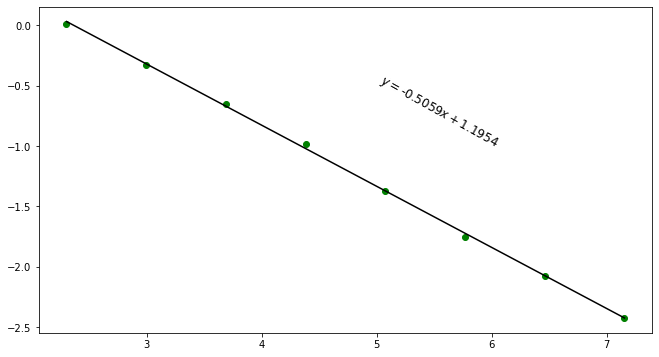

In [13]:
k = 8
num_of_sim = 1000
num_of_steps = np.zeros(k, dtype = int)
mean_errors = np.zeros(k)

for i in range(k):
    N = 10 * 2 ** i
    num_of_steps[i] = N
    sum_of_errors = 0
    for j in range(num_of_sim):
        sum_of_errors += Euler_error(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)
    mean_errors[i] = sum_of_errors / num_of_sim

X = np.log(num_of_steps)
Y = np.log(mean_errors)

X = X.reshape((-1, 1))
model = LinearRegression().fit(X, Y)

print("Tempo zbieżności schematu Eulera wynosi: ", model.coef_[0])

# Wykres

plt.figure(figsize = (11, 6))
plt.scatter(X, Y, color = 'g')
plt.plot(X, model.predict(X), color = 'k')
plt.text(5, -1, '$y=$'+str(round(model.coef_[0], 4))+'$x +$'+str(round(model.intercept_, 4)), fontsize = 12, rotation = -29)

d = {'N': num_of_steps, 'error' :mean_errors}
df = pd.DataFrame(d)
df

## Jump-Adapted Scheme

### Tempo zbieżności $\gamma= 1.0$

W metodzie rozważamy podział odcinka $\left[0,T\right]$ postaci 

### $$0=t_{0}<t_{1}<...<t_{M}=T,$$

który jest połączeniem dokładnych momentów skoków $\left\{ \tau_{1},\tau_{2},...,\tau_{N\left(T\right)}\right\}$  oraz siatki równomiernej w której pojedyńczy krok wynosi $\Delta t=\frac{T}{N}$. Ponieważ w siatce uwazględniamy wszystkie momenty skoków, to pomiędzy kolejnymi skokami proces $S$ jest po prostu procesem dyfuzji. 

Niech $S_{t_{n+1}-}=\lim_{s\to t_{n+1}-}S_{s}$. Wówczas omawiany schemat prezentuje się następująco:

## $$\boxed{S_{t_{n+1}-}=S_{t_{n}}+a\left(S_{t_{n}}\right)\Delta_{t_{n}}+b\left(S_{t_{n}}\right)\Delta W_{n}+\frac{b\left(S_{t_{n}}\right)b'\left(S_{t_{n}}\right)}{2}\left[\left(\Delta W_{t_{n}}\right)^{2}-\Delta_{t_{n}}\right]}$$

## $$\boxed{S_{t_{n+1}}=S_{t_{n+1}-}+c(S_{t_{n+1}-})\left(J_{t_{n+1}}-J_{t_{n}}\right)}$$

### Złożony proces Poissona (dokładne momenty skoków)

In [14]:
def Compound_Poisson_path(T, N, lam, p, eta_1, eta_2):
        
    X = []  # lista zawierająca czasy oczekiwania na kolejne skoki
    k = np.random.exponential(1 / lam)  # czas oczekiwania na skok
    
    while np.sum(X) + k <= T: # generujemy momenty skoków do chwili T
        X.append(k)
        k = np.random.exponential(1 / lam)

    num_of_jumps = len(X) # liczba wszystkich skoków, czyli po prostu N(T) 
    x1 = np.zeros(num_of_jumps) # tworzymy os czasu - tyle punkow ile skokow
    y1 = np.zeros(num_of_jumps) # wartości złożonego procesu Poissona w punktach skoków

    jumps_exact = DExp(p, eta_1, eta_2, num_of_jumps) # generujemy skoki z rozkladu podwojnie wykladniczego (dla rozwiązania dokładnego)
    jumps = np.exp(jumps_exact) - 1 # wielkosci skoków (dla jump-adapted scheme)
 
    # trajektorie złożonego procesu Poissona dla dokładnych punktów skoków (bez chwili t = 0)
    for i in range(num_of_jumps):
        x1[i] = np.sum(X[:i + 1]) # oś czasu (dokładne czasy skokow) - sumujemy czasy oczekiwania na kolejne skoki
        y1[i] = np.sum(jumps[:i + 1]) # wartość zł. pr. Poissona w punktach skoków
    
    h = float(T / N)
    x2 = np.zeros(N + 1) # oś czasu (siatka równomierna)
    y2 = np.zeros(N + 1) # wartości zł. pr. Poissona na siatce równomiernej
        
    # trajektorie złożonego procesu Poissona na siatce równomiernej
    for i in range(N): 
        x2[i + 1] = x2[i] + h 
        num_of_jumps = np.sum(x1 <= x2[i + 1]) # liczba skoków do chwili x2[i + 1]
        y2[i + 1] = np.sum(jumps[:num_of_jumps]) # wartosc zl pr. Poissona w chwili x[i + 1]        
     
    t = np.concatenate((x1, x2), axis=0)  # łaczymy momenty skoków z siatką równomierną
    J = np.concatenate((y1, y2), axis=0)  # łączymy wartości zł. pr. Poissona z obu siatek
    zipped = list(zip(t, J))  # tworzymy pary (t, J)
    sorted_zip = sorted(zipped, key = lambda x: x[0]) # sortujemy pary rosnąco względem pierwszego elementu (czyli po czasie)
    t = np.array([x[0] for x in sorted_zip]) # rozdzielamy posortowane już pary (t, Y) na osobne wektory (czas i wartość) 
    J = np.array([x[1] for x in sorted_zip])
      
    sum_of_jumps = np.sum(jumps_exact)  # suma skoków potrzebna dla rozwiązania dokładnego w chwili T
    
    return t, J, sum_of_jumps

In [15]:
def Jump_adapted_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    t, J, Y = Compound_Poisson_path(T, N, lam, p, eta_1, eta_2)
    
    N_ = len(t)  # liczba elementów siatki
    S = np.zeros(N_)  # tworzymy wektor wartości dla procesu S
    S[0] = S0
    
    W = np.zeros(N_)  # proces Wienera
    
    # generujemy trajektorie procesu S
    for i in range(N_ - 1):
        h = t[i + 1] - t[i]
        dW = np.sqrt(h) * np.random.normal(0, 1)
        W[i + 1] = W[i] + dW
        S[i + 1] = S[i] + a(S[i]) * h + b(S[i]) * dW + 0.5 * sigma ** 2 * S[i] * (dW ** 2 - h) # wartość przed skokiem
        S[i + 1] = S[i + 1] + c(S[i + 1]) * (J[i + 1] - J[i])   # wartość po skoku
    
    return t, S, W[N_ - 1], Y  

### Asymptotyczne tempo zbieżności

In [16]:
def Jump_adapted_error(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    S, W, Y = Jump_adapted_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1:]
    
    S_T_exact = exact_value_T(S0, T, r, q, sigma, lam, p, eta_1, eta_2, W, Y)
    error = np.abs(S_T_exact - S[-1])
    
    return error

Tempo zbieżności wynosi: -0.9865343897834478


,N,error
0,10,0.068533
1,20,0.036476
2,40,0.018205
3,80,0.009508
4,160,0.004901
5,320,0.002311
6,640,0.001179
7,1280,0.000578


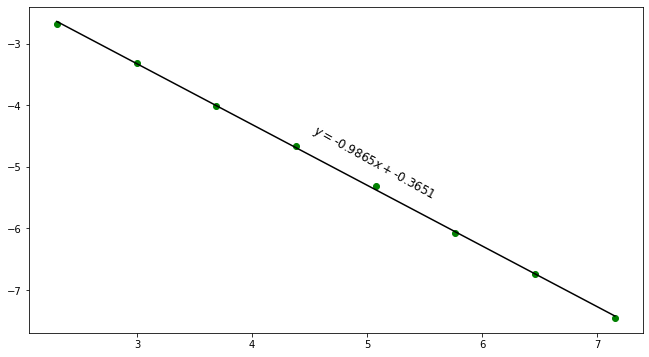

In [17]:
# Sprawdzamy czy tempo zbieżności wynosi 1.0:
k = 8
num_of_sim = 1000
num_of_steps = np.zeros(k, dtype = int)
mean_errors = np.zeros(k)

for i in range(k):
    N = 10 * 2 ** i
    num_of_steps[i] = N
    sum_of_errors = 0
    for j in range(num_of_sim):
        sum_of_errors += Jump_adapted_error(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)
    mean_errors[i] = sum_of_errors / num_of_sim
    
X = np.log(num_of_steps)
Y = np.log(mean_errors)

X = X.reshape((-1, 1))
model = LinearRegression().fit(X, Y)

print("Tempo zbieżności wynosi: " + str(model.coef_[0]))

plt.figure(figsize = (11, 6))
plt.scatter(X, Y, color = 'g')
plt.plot(X, model.predict(X), color = 'k')
plt.text(4.5, -5.5, '$y=$'+str(round(model.coef_[0], 4))+'$x +$'+str(round(model.intercept_, 4)), fontsize = 12, rotation = -29)

d = {'N': num_of_steps, 'error': mean_errors}
pd.DataFrame(d)

### Tempo zbieżności $\gamma = 1.5$

Stosując poniższy schemat uzyskujemy tempo zbieżności na poziomie $\gamma = 1.5$:

### $$\boxed{\begin{aligned}[t]
	S_{t_{n+1}-}&=S_{t_{n}}+a\left(S_{t_{n}}\right)\Delta_{t_{n}}+b\left(S_{t_{n}}\right)\Delta W_{t_n}+\frac{b\left(S_{t_{n}}\right)b^{'}\left(S_{t_{n}}\right)}{2}\left(\left[\Delta W_{t_{n}}\right]^{2}-\Delta_{t_{n}}\right)\\
	&+a'\left(S_{t_{n}}\right)b\left(S_{t_{n}}\right)\Delta Z_{t_{n}}+\frac{1}{2}\left(a\left(S_{t_{n}}\right)a'\left(S_{t_{n}}\right)+\frac{1}{2}b^{2}\left(S_{t_{n}}\right)a''\left(S_{t_{n}}\right)\right)\left(\Delta t_{n}\right)^{2} \\
    &+\left(a\left(S_{t_{n}}\right)b'\left(S_{t_{n}}\right)+\frac{1}{2}b^{2}\left(S_{t_{n}}\right)b''\left(S_{t_{n}}\right)\right)\left(\Delta W_{t_{n}}\Delta t_{n}-\Delta Z_{t_{n}}\right) \\
    &+\frac{1}{2}b\left(S_{t_{n}}\right)\left(b\left(S_{t_{n}}\right)b''\left(S_{t_{n}}\right)+\left[b'\left(S_{t_{n}}\right)\right]^{2}\right)\left(\frac{1}{3}\left[\Delta W_{t_{n}}\right]^{2}-\Delta t_{n}\right)\Delta W_{t_{n}},
	\end{aligned}}$$
    
### $$\boxed{S_{t_{n+1}}=S_{t_{n+1}-}+c(S_{t_{n+1}-})\left(J_{t_{n+1}}-J_{t_{n}}\right)}$$

gdzie

### $$\Delta Z_{t_{n}}=\int_{0}^{t_{n+1}}\int_{t_{n}}^{s_{2}}dW_{s_{1}}ds_{2}\sim\mathcal{N}\left(0,\frac{1}{3}\left(\Delta t_{n}\right)^{3}\right)$$

oraz

### $$\text{Cov}\left(\Delta Z_{t_{n}},\Delta W_{t_{n}}\right)=\frac{1}{2}\left(\Delta t_{n}\right)^{2}.$$

Skorelowane procesy $\Delta Z_{t_{n}}$ i $\Delta W_{t_{n}}$ będziemy symulować w następujący sposób:

### $$\Delta W_{t_{n}}=U_{1}\sqrt{\Delta t_{n}}\quad{\rm oraz}\quad\Delta Z_{t_{n}}=\frac{1}{2}\left(\Delta t_{n}\right)^{\frac{3}{2}}\left(U_{1}+\frac{1}{\sqrt{3}}U_{2}\right),\qquad U_{1},U_{2}\sim\mathcal{N}\left(0,1\right).$$

In [18]:
def Jump_adapted_v2_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    t, J, Y = Compound_Poisson_path(T, N, lam, p, eta_1, eta_2)
    
    N_ = len(t)  # liczba elementów siatki
    S = np.zeros(N_)  # tworzymy wektor wartości dla procesu S
    S[0] = S0
    
    W = np.zeros(N_)  # proces Wienera
    
    # generujemy trajektorie procesu S
    for i in range(N_ - 1):
        h = t[i + 1] - t[i]
        U = np.random.normal(0, 1, 2)
        dW = np.sqrt(h) * U[1]
        dZ = 0.5 * h ** (3 / 2) * (U[0] + U[1] / np.sqrt(3))
        W[i + 1] = W[i] + dW
        S[i + 1] = S[i] + a(S[i]) * h + b(S[i]) * dW + 0.5 * sigma ** 2 * S[i] * (dW ** 2 - h) \
                   + a_x(S[i]) * b(S[i]) * dZ + 0.5 * (a(S[i]) * a_x(S[i]) + 0.5 * b(S[i]) ** 2 * a_xx(S[i])) * h ** 2 \
                   + (a(S[i]) * b_x(S[i]) + 0.5 * b(S[i]) ** 2 * b_xx(S[i])) * (dW * h - dZ) \
                   + 0.5 * b(S[i]) * (b(S[i]) * b_xx(S[i]) + b_x(S[i]) ** 2) * (1 / 3 * dW ** 2 - h) * dW 
        S[i + 1] = S[i + 1] + c(S[i + 1]) * (J[i + 1] - J[i])   # wartość po skoku
    
    return t, S, W[N_ - 1], Y  

In [19]:
def Jump_adapted_v2_error(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2):
    
    S, W, Y = Jump_adapted_v2_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1:]
    
    S_T_exact = exact_value_T(S0, T, r, q, sigma, lam, p, eta_1, eta_2, W, Y)
    error = np.abs(S_T_exact - S[-1])
    
    return error

Tempo zbieżności wynosi: -1.4820890962211029


,N,error
0,10,2.725889e-03
1,20,1.096871e-03
2,40,4.046673e-04
3,80,1.391371e-04
4,160,5.142301e-05
5,320,1.809147e-05
6,640,6.590304e-06
7,1280,2.163486e-06
8,2560,7.856662e-07
9,5120,2.858851e-07


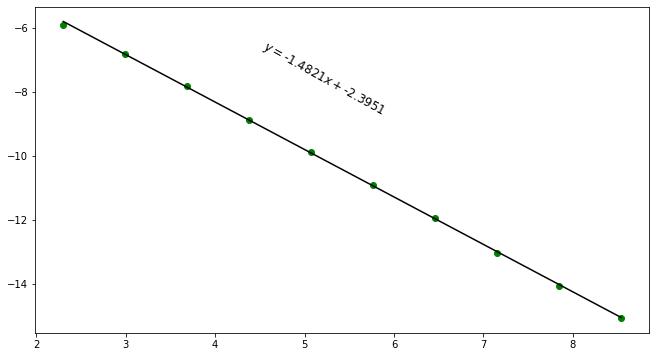

In [20]:
# Sprawdzamy czy tempo zbieżności wynosi 1.5:
k = 10
num_of_sim = 1000
num_of_steps = np.zeros(k, dtype = int)
mean_errors = np.zeros(k)

for i in range(k):
    N = 10 * 2 ** i
    num_of_steps[i] = N
    sum_of_errors = 0
    for j in range(num_of_sim):
        sum_of_errors += Jump_adapted_v2_error(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)
    mean_errors[i] = sum_of_errors / num_of_sim
    
X = np.log(num_of_steps)
Y = np.log(mean_errors)

X = X.reshape((-1, 1))
model = LinearRegression().fit(X, Y)

print("Tempo zbieżności wynosi: " + str(model.coef_[0]))

# wykres
plt.figure(figsize = (11, 6))
plt.scatter(X, Y, color = 'g')
plt.plot(X, model.predict(X), color = 'k')
plt.text(4.5, -8.7, '$y=$'+str(round(model.coef_[0], 4))+'$x +$'+str(round(model.intercept_, 4)), fontsize = 12, rotation = -29)

d = {'N': num_of_steps, 'error': mean_errors}
pd.DataFrame(d)

## Porównanie czasów wykonania dla poznanych metod

In [21]:
num_of_sim = 1000

start1 = time.time()
for i in range(num_of_sim):
    exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)   
end1 = time.time()
time1 = (end1 - start1) 

start2 = time.time()
for i in range(num_of_sim):
    Euler_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)
end2 = time.time()
time2 = (end2 - start2) 

start3 = time.time()
for i in range(num_of_sim):
    Jump_adapted_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)      
end3 = time.time()
time3 = (end3 - start3)

start4 = time.time()
for i in range(num_of_sim):
    Jump_adapted_v2_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)      
end4 = time.time()
time4 = (end4 - start4) 



print("Czas generowania ", num_of_sim, " ścieżek (rozwiązanie dokładne): {:.1f}s".format(time1))
print("Czas generowania ", num_of_sim, " ścieżek (Euler Scheme): {:.1f}s".format(time2))
print("Czas generowania ", num_of_sim, " ścieżek (Jump-adapted scheme): {:.1f}s".format(time3))
print("Czas generowania ", num_of_sim, " ścieżek (Jump-adapted scheme v2): {:.1f}s".format(time4))


Czas generowania  1000  ścieżek (rozwiązanie dokładne): 11.4s
Czas generowania  1000  ścieżek (Euler Scheme): 114.8s
Czas generowania  1000  ścieżek (Jump-adapted scheme): 117.8s
Czas generowania  1000  ścieżek (Jump-adapted scheme v2): 195.6s


# Wycena opcji

## Opcja Europejska

In [22]:
T = 1 
N = 252
S0 = 100
K = 95

In [23]:
def Payoff(S_T, K, CallPut): 
    return np.maximum(S_T - K, 0) if CallPut == "call" else np.maximum(K - S_T, 0)

In [24]:
def vanilla_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut):
    
    payoffs = np.zeros(num_of_sim)
    
    for i in range(num_of_sim):
        S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
        payoffs[i] = Payoff(S[-1], K, CallPut)
        
    return np.exp(-r * T) * np.mean(payoffs)

In [25]:
call_price = vanilla_price(S0, K, T, 1, r, q, sigma, lam, p, eta_1, eta_2, 100000, "call")
print("Cena europejskiej opcji call wynosi: ", call_price)

Cena europejskiej opcji call wynosi:  12.19022148360022


# Opcja Barierowa

### Z pojedyńczą bariera

In [26]:
def barrier_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut, barrier, BarType):

    payoffs = []
    
    if BarType == "UO":
        for i in range(1, num_of_sim + 1):
            S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
            if np.max(S) >= barrier:
                payoff = 0
            else: payoff = Payoff(S[-1], K, CallPut)
            payoffs.append(payoff)
        return np.exp(-r * T) * np.mean(payoffs)
        
    elif BarType == "UI":
        for i in range(1, num_of_sim + 1):
            S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
            if np.max(S) < barrier:
                payoff = 0
            else: payoff = Payoff(S[-1], K, CallPut)
            payoffs.append(payoff)
        return np.exp(-r * T) * np.mean(payoffs)
    
    elif BarType == "DO":
        for i in range(1, num_of_sim + 1):
            S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
            if np.min(S) <= barrier:
                payoff = 0
            else: payoff = Payoff(S[-1], K, CallPut)
            payoffs.append(payoff)
        return np.exp(-r * T) * np.mean(payoffs)
    
    elif BarType == "DI":
        for i in range(1, num_of_sim + 1):
            S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
            if np.min(S) > barrier:
                payoff = 0
            else: payoff = Payoff(S[-1], K, CallPut)
            payoffs.append(payoff)
        return np.exp(-r * T) * np.mean(payoffs)

In [27]:
barrier = 90
barrier_price_ = barrier_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, 10000, "call", barrier, "DO")

print("Cena opcji barierowej Down-and-Out Call wynosi: ", barrier_price_)

Cena opcji barierowej Down-and-Out Call wynosi:  9.310555672912066


### Z podwójną barierą 

In [28]:
def double_barrier_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut, \
                         barrier_down, barrier_up, InOut):
    
    payoffs = np.zeros(num_of_sim)
    
    if InOut == "In":
        for i in range(1, num_of_sim + 1):
            S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
            if (np.max(S) >= barrier_up or np.min(S) <= barrier_down):
                payoffs[i - 1] = Payoff(S[-1], K, CallPut)
            else: payoffs[i - 1] = 0
        return np.exp(-r * T) * np.mean(payoffs)

    if InOut == "Out":
        for i in range(1, num_of_sim + 1):
            S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
            if (np.max(S) < barrier_up and np.min(S) > barrier_down):
                payoffs[i - 1] = Payoff(S[-1], K, CallPut)
            else: payoffs[i - 1] = 0
                
        return np.exp(-r * T) * np.mean(payoffs)

In [29]:
barrier_up = 150
barrier_down = 80

double_barrier_price_ = double_barrier_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, 10000, "call", barrier_down, barrier_up, "In")

print("Cena opcji Call z podwójną barierą typu In wynosi: ", double_barrier_price_)

Cena opcji Call z podwójną barierą typu In wynosi:  4.5118152471725805


# Opcja Lookback

### Ze stałą ceną realizacji (fixed strike lookback option)
#### $$H_{\rm{call}} = \left(\max_{t\in [0,T]}S_t - K, 0\right)^+$$
#### $$H_{\rm{put}} = \left(K - \min_{t\in [0,T]}S_t, 0\right)^+$$

In [30]:
def fixed_lookback_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut):
    
    payoffs = np.zeros(num_of_sim)
    
    for i in range(num_of_sim):
        S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
        payoffs[i] = np.maximum(np.max(S) - K, 0) if CallPut == "call" else np.maximum(K - np.min(S), 0)
    
    return np.exp(-r * T) * np.mean(payoffs)

In [31]:
fixed_lookback_price_ = fixed_lookback_price(S0, K, T, N, r, q, sigma, lam, p, eta_1, eta_2, 10000, "call")

print("Cena opcji Lookback Call ze stałą ceną realizacji wynosi: ", fixed_lookback_price_)

Cena opcji Lookback Call ze stałą ceną realizacji wynosi:  24.076120047506265


### Ze zmienną ceną realizacji (floating strike lookback option)
#### $$H_{\rm{call}} = S_T - \min_{t\in [0,T]}S_t$$
#### $$H_{\rm{put}} = \max_{t\in [0,T]}S_t - S_T$$

In [32]:
def floating_lookback_price(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut):
    
    payoffs = np.zeros(num_of_sim)
    
    for i in range(num_of_sim):
        S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
        payoffs[i] = S[-1] - np.min(S) if CallPut == "call" else np.max(S) - S[-1]
    
    return np.exp(-r * T) * np.mean(payoffs)

In [33]:
floating_lookback_price_ = floating_lookback_price(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2, 10000, 'call')

print("Cena opcji Lookback Call ze zmienną ceną realizacji wynosi: ", floating_lookback_price_)

Cena opcji Lookback Call ze zmienną ceną realizacji wynosi:  16.703031454212507


# Opcja azjatycka

### Średnia geometryczna

#### $$H_{\rm{call}} = \left(\left[\prod_{i=1}^{N}S_{t_i}\right]^{1/N} - K\right)^{+}$$
#### $$H_{\rm{put}} = \left(K - \left[\prod_{i=1}^{N}S_{t_i}\right]^{1/N}\right)^{+}$$

In [34]:
def geometric_asian_price(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut):

    payoffs = np.zeros(num_of_sim)
    
    for i in range(num_of_sim):
        S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
        geom_aver = 1
        for j in range(1, N + 1):
            geom_aver *= S[j] ** (1 / N)
        payoffs[i] = np.maximum(geom_aver - K, 0) if CallPut == "call" \
                 else np.maximum(K - geom_aver, 0)
    
    return np.exp(-r * T) * np.mean(payoffs)

In [35]:
geom_price = geometric_asian_price(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2, 10000, "call")
print("Cena Azjatyckiej opcji Call ze średnią geometryczną wynosi: ", geom_price)

Cena Azjatyckiej opcji Call ze średnią geometryczną wynosi:  7.951617208540079


### Średnia arytmetyczna

#### $$H_{\rm{call}} = \left(\frac{1}{N}\sum_{i=1}^{N}S_{t_i} - K\right)^{+}$$
#### $$H_{\rm{put}} = \left(K - \frac{1}{N}\sum_{i=1}^{N}S_{t_i}\right)^{+}$$

In [36]:
def arithmetic_asian_price(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2, num_of_sim, CallPut):

    payoffs = np.zeros(num_of_sim)
    
    for i in range(num_of_sim):
        S = exact_path(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2)[1]
        arithmetic_average = np.mean(S[1:])
        payoffs[i] = np.maximum(arithmetic_average - K, 0) if CallPut == "call" \
                                else np.maximum(K - arithmetic_average, 0)
    
    return np.exp(-r * T) * np.mean(payoffs)

In [37]:
arithmetic_price = arithmetic_asian_price(S0, T, N, r, q, sigma, lam, p, eta_1, eta_2, 10000, "call")
print("Cena Azjatyckiej opcji Call ze średnią arytmetyczną wynosi: ", arithmetic_price)

Cena Azjatyckiej opcji Call ze średnią arytmetyczną wynosi:  8.478093672305723


# Bibliografia
$\textit{Approximation of Jump Diffusions in Finance and Economics}$, 

$\textbf{Nicola Bruti-Liberati and Eckhard Platen}$

https://www.uts.edu.au/sites/default/files/qfr-archive-02/QFR-rp176.pdf